<a href="https://colab.research.google.com/github/aminecloud9/PFE/blob/main/NSLKDD_Originaldata_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import StandardScaler
from collections import Counter
from matplotlib import pyplot
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import time
from imblearn.under_sampling import CondensedNearestNeighbour

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
pip install git+https://github.com/artemmavrin/focal-loss.git

In [ ]:
pip install focal-loss

Download dataset

In [2]:
#data=pd.read_csv('/content/drive/MyDrive/CICIDS2017_multi_class_StandardScaler_NormalsationResults.csv')
#train_data = pd.read_csv('/content/drive/MyDrive/KDDTrain+.csv', header = None,nrows=1) # read just first line for columns
#columns = train_data.columns.tolist() # get the columns
#cols_to_use = columns[:len(columns)-1] 
train_data=pd.read_csv('/content/drive/MyDrive/KDDTrain+.csv',header=None)
train_data = train_data.iloc[:, :-1]# drop the last one
#train_data = train_data.iloc[:, 1:]# drop the first one
test_data=pd.read_csv('/content/drive/MyDrive/KDDTest+.csv',header=None)
test_data = test_data.iloc[:, :-1]# drop the last one
#train_data = train_data.iloc[:, 1:]# drop the first one

In [ ]:
train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,184,25,1.0,1.0,0.0,0.0,0.14,0.06,0.00,255,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,dos
125969,8,udp,private,SF,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.00,255,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,8,1.0,1.0,0.0,0.0,0.06,0.05,0.00,255,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos


Data nemerisation

In [3]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
train_data[[1]] = enc.fit_transform(train_data[[1]])
test_data[[1]] = enc.fit_transform(test_data[[1]])

train_data[[2]] = enc.fit_transform(train_data[[2]])
test_data[[2]] = enc.fit_transform(test_data[[2]])

train_data[[3]] = enc.fit_transform(train_data[[3]])
test_data[[3]] = enc.fit_transform(test_data[[3]])

Train and test data formatting

In [11]:
train_X = train_data.values[:,:-1]
train_y = pd.factorize(train_data.values[:,-1])
test_X = test_data.values[:,:-1]
test_y = pd.factorize(test_data.values[:,-1])

Data scaling

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X=scaler.fit_transform(train_X)
test_X = scaler.fit_transform(test_X)

Data augmentation

Class=0, n=67343 (3367150.000%)
Class=1, n=45927 (2296350.000%)
Class=2, n=995 (49750.000%)
Class=3, n=11656 (582800.000%)
Class=4, n=52 (2600.000%)


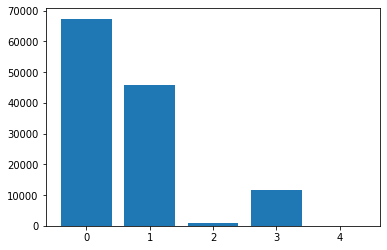

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 11656, 1: 11656, 2: 11656, 3: 11656, 4: 11656})


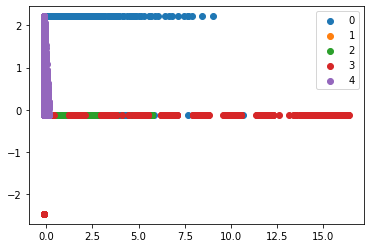

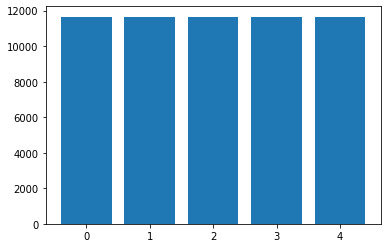

In [13]:
# Oversample and plot imbalanced dataset with SMOTE
# summarize distribution
counter = Counter(train_y[0])
for k,v in counter.items():
	per = v / len(train_y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()
# transform the dataset
oversample = SMOTE(sampling_strategy={2:11656 , 4:11656 })
under = RandomUnderSampler(sampling_strategy={0:11656, 1:11656 })
steps = [('u', under),('o',oversample)]
pipeline = Pipeline(steps=steps)
train_X, train_y = pipeline.fit_resample(train_X, train_y[0])
# summarize the new class distribution
counter = Counter(train_y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(train_y == label)[0]
	pyplot.scatter(train_X[row_ix, 0], train_X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
# summarize distribution
counter = Counter(train_y[0])
for k,v in counter.items():
	per = v / len(train_y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()
# transform the dataset
undersample = CondensedNearestNeighbour(n_neighbors=1)(sampling_strategy={0:11656, 1:11656 })
train_X, train_y = pipeline.fit_resample(train_X, train_y[0])
# summarize the new class distribution
counter = Counter(train_y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(train_y == label)[0]
	pyplot.scatter(train_X[row_ix, 0], train_X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

pyplot.bar(counter.keys(), counter.values())
pyplot.show()

reshape input to be [samples, time steps, features]

In [14]:
import keras
#X_train = np.reshape(data.values[:,:-1].astype('float32'), (data.values[:,:-1].shape[0], 1, data.values[:,:-1].shape[1]))
X_train = np.reshape(train_X.astype('float32'), (train_X.shape[0], 1, train_X.shape[1]))
X_test = np.reshape(test_X.astype('float32'), (test_X.shape[0], 1, test_X.shape[1]))
#y_train = keras.utils.to_categorical(pd.factorize(data.values[:,77])[0],15)
y_train = keras.utils.to_categorical(train_y[0],5)
y_train = y_train.astype('int')
#y_train = np.reshape(y_train,(y_train.shape[0],1,y_train.shape[1]))
y_test = keras.utils.to_categorical(test_y[0],5)
y_test = y_test.astype('int')
#y_test = np.reshape(y_test,(y_test.shape[0],1,y_test.shape[1]))

In [ ]:
X_train.shape

(125973, 1, 41)

Define the network

In [ ]:
#train_object_num=len(train_data)
#print(test[0])
#model training
batch_size = 128
lrate = 0.3
DROPOUTRATE = 0.1
model=Sequential()
model.add(LSTM(X_train.shape[2],input_dim=X_train.shape[2],return_sequences=True,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(LSTM(32,kernel_initializer='uniform',return_sequences=True,activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(LSTM(32,kernel_initializer='uniform',return_sequences=True,activation='relu'))
model.add(Dropout(DROPOUTRATE))
#model.add(Dense(256,activation='relu'))
#model.add(Dropout(DROPOUTRATE))
#model.add(Dense(128,activation='relu'))
#model.add(Dropout(DROPOUTRATE))
model.add(Dense(64,activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(16,activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(y_train.shape[2],activation='sigmoid'))
opt = SGD(lr=lrate)
model.compile(loss='binary_crossentropy',optimizer='ADAM',metrics=['accuracy'])
model.summary()
start_time = time.time()
history = model.fit(X_train,y_train,validation_split=.3,epochs=100,batch_size=batch_size,verbose=1)
finish_time = time.time() - start_time
#model.save("/content/drive/My Drive/model_NSL-KDD_scaled_Multiclass_valsplit.3_bs1024_100ep.h5")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 41)          13612     
_________________________________________________________________
dropout_15 (Dropout)         (None, None, 41)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          9472      
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
dense_15 (Dense)             (None, None, 64)         

KeyboardInterrupt: ignored

saving model

In [ ]:
model.save("/content/drive/MyDrive/NSL-KDD_42norm_results_5Dense_po_Dropout_200epoch_1024batch_model.h5")

In [ ]:
y_pred

In [ ]:
42 col pca 80% : b_s=256 epochs= 300 Lstm(32,32)->Dense(256,128,64,ytrain.shape(2))   ->   accuracy = 62.8%


24 col normalisé : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 83.73%
24 col pca 80% : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 40.28%
42 col normalisé : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 48.52%
42 col pca 80% : b_s=1024 epochs= 100 Lstm(32,32)->Dense(256,128,64,16,ytrain.shape(2))   ->   accuracy = 45.22%
24 col pca 80% : b_s=1024 epochs= 100 Lstm(32,32)->Dense(64,16,ytrain.shape(2))   ->   accuracy = 42.58%


In [ ]:
# focal loss with multi label
def focal_loss(classes_num, gamma=2., alpha=.25, e=0.1):
    # classes_num contains sample number of each classes
    def focal_loss_fixed(target_tensor, prediction_tensor):
        '''
        prediction_tensor is the output tensor with shape [None, 100], where 100 is the number of classes
        target_tensor is the label tensor, same shape as predcition_tensor
        '''
        #1# get focal loss with no balanced weight which presented in paper function (4)
        zeros = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)
        one_minus_p = array_ops.where(np.max(target_tensor,zeros), target_tensor - prediction_tensor, zeros)
        FT = -1 * (one_minus_p ** gamma) * tf.log(tf.clip_by_value(prediction_tensor, 1e-8, 1.0))

        #2# get balanced weight alpha
        classes_weight = array_ops.zeros_like(prediction_tensor, dtype=prediction_tensor.dtype)

        total_num = float(sum(classes_num))
        classes_w_t1 = [ total_num / ff for ff in classes_num ]
        sum_ = sum(classes_w_t1)
        classes_w_t2 = [ ff/sum_ for ff in classes_w_t1 ]   #scale
        classes_w_tensor = tf.convert_to_tensor(classes_w_t2, dtype=prediction_tensor.dtype)
        classes_weight += classes_w_tensor

        #alpha = array_ops.where(tf.greater(np.array(target_tensor, dtype=np.float32), zeros), classes_weight, zeros)

        #3# get balanced focal loss
        balanced_fl = alpha * FT
        balanced_fl = tf.reduce_mean(balanced_fl)

        #4# add other op to prevent overfit
        # reference : https://spaces.ac.cn/archives/4493
        nb_classes = len(classes_num)
        fianal_loss = (1-e) * balanced_fl + e * K.categorical_crossentropy(K.ones_like(prediction_tensor)/nb_classes, prediction_tensor)

        return fianal_loss
    return focal_loss_fixed

In [ ]:
def focal_loss(classes_num, gamma=2., alpha=.25, e=0.1):
  def focal_loss_fixed(target_tensor, prediction_tensor):
    tot_num = sum(classes_num)
    alpha = classes_num/tot_num
    mask = np.eye(alpha.shape[1])
    loss = (prediction_tensor*mask - target_tensor*mask)*(prediction_tensor*mask - target_tensor*mask)
    fianal_loss = sum(alpha*loss)
    return fianal_loss
return focal_loss_fixed

In [ ]:
Xtr

In [ ]:
batch_size= 128
lrate = 0.1
DROPOUTRATE = 0.1
model = Sequential()
model.add(Dense(X_train.shape[2], input_dim=X_train.shape[2], activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(768, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(512, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(256, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(128, activation='relu'))
model.add(Dropout(DROPOUTRATE))
model.add(Dense(y_train.shape[2], activation='softmax'))
	# compile model
opt = SGD(lr=lrate)
#loss = categorical_focal_loss([67343,45927,995,11656,52])
model.compile(loss= 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit model
model.summary()
start_time = time.time()
history = model.fit(X_train, y_train, validation_data = (X_test,y_test),batch_size=batch_size, epochs=10, verbose=1)
finish_time = time.time() - start_time

In [ ]:
model = Sequential()
model.add(GRU(128, input_shape=(1,41)))
model.add(Dropout(0.2))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()
history = model.fit(X_train, y_train,
          epochs=30,
          batch_size=64, validation_split=0.1, verbose=1)
score = model.evaluate(X_test, y_test, batch_size=32)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 128)               65664     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 48)                6192      
_________________________________________________________________
dropout_27 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 48)                2352      
_________________________________________________________________
dropout_28 (Dropout)         (None, 48)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)                

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
loss, accuracy = model.evaluate(X_test,y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
y_pred = model.predict_classes(X_test)
target_names = ['Normal', 'Dos', 'Probe','R2L', 'U2R']
print(classification_report(y_true = np.transpose(test_y[0]), y_pred = y_pred))
#print(accuracy_score(y_true = np.transpose(test_y[0]), y_pred = y_pred))
print("execution time :  ",finish_time)

705/705 [==============================] - 1s 1ms/step - loss: 17.8440 - accuracy: 0.0780

Loss: 17.84, Accuracy: 7.80%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.11      0.22      0.15      7458
           1       0.01      0.01      0.01      9710
           2       0.00      0.00      0.00      2421
           3       0.00      0.00      0.00      2754
           4       0.79      0.10      0.17       200

    accuracy                           0.08     22543
   macro avg       0.18      0.07      0.07     22543
weighted avg       0.05      0.08      0.06     22543



NameError: ignored

In [ ]:
from keras.models import load_model
#model = load_model('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_model.hdf5')
loss, accuracy = model.evaluate(X_test, y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

#print("--- %s seconds ---",finish_time)
y_pred = model.predict(X_train)
#np.savetxt('/content/drive/MyDrive/NSL-KDD_results_SimpleRNN_predicted.txt', np.transpose([y_test,y_pred]), fmt='%s')

705/705 [==============================] - 1s 1ms/step - loss: 18.6579 - accuracy: 0.0743

Loss: 18.66, Accuracy: 7.43%


In [ ]:
from matplotlib import pyplot
# plot accuracy
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.title('lrate='+str(lrate), pad=-50)


In [ ]:

# plot leoss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('lrate='+str(lrate), pad=-50)